<a href="https://colab.research.google.com/github/IamShubhamGupto/WSSL-Weighted-Self-Supervised-Learning-for-Image-Inpainting/blob/main/notebooks/P2R3/Saturation_Pretext.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 24.29 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [ ]:
# !pip install tensorflow==2.1

In [ ]:
import time
import scipy.ndimage as nd
import scipy.misc
import cv2
import numpy as np
import os
import glob
import gc
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from PIL import Image, ImageEnhance
from random import randint
import pandas as pd

from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, concatenate
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
import plotly.graph_objects as go
%matplotlib inline
import random as rn
np.random.seed(4321)
rn.seed(4321)
tf.random.set_seed(4321)

Extract test and training data from Tiny ImageNet DataSet

In [ ]:

# path = '/content/drive/MyDrive/saved_images'

path = 'IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread( path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread( path + 'val/images/{}'.format(img_name)))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
# train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

# print( "train data shape: ",  train_data.shape )
# print( "train label shape: ", train_labels.shape )
# print( "test data shape: ",   test_data.shape )
# print( "test_labels.shape: ", test_labels.shape )

# del train_labels
# del test_labels
# gc.collect()

In [ ]:
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())
print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 18.3310489654541 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [ ]:
# def rot_imgs(x):
#     resX = []
#     resY = []
#     # plot first few images
#     for i in range(len(x)):
#         # define subplot
#         # plt.subplot(330 + 1 + i)
#         rotate = randint(0,3)
#         if rotate == 0:
#           resX.append(x[i])
#           resY.append(0)
#         elif rotate == 1:
#           res = np.rot90(x[i])
#           resX.append(res)
#           resY.append(1)
#         elif rotate == 2:  
#           res = np.rot90(x[i],2)
#           resX.append(res)
#           resY.append(2)
#         else:
#           res = np.rot90(x[i],3)
#           resX.append(res)
#           resY.append(3)

#     ds = np.array(list(zip(resX,resY)))
#     np.random.shuffle(ds)
#     resX2 = []
#     resY2 = []
#     for x,y in ds:
#       resX2.append(x)
#       resY2.append(y)
#     return (np.array(resX2),np.array(resY2))

In [ ]:

def sat_image():
  return randint(0,3)


In [ ]:
IM_WIDTH = IM_HEIGHT = 64
TRAIN_TEST_SPLIT = 0.8
dataset_dict = {
    'sat_id': {
        0: '0.0',
        1: '0.25',
        2: '0.75',
        3: '1'
    }
}
dataset_dict['sat_alias'] = dict((r, i) for i, r in dataset_dict['sat_id'].items())

In [ ]:
def prepare_dataset(dataset, ext='JPEG'):
    def generate_sat():
      res_sat = sat_image()

      return [res_sat]
      # return dataset_dict['rotation_id'][res_rot], dataset_dict['sharpness_id'][res_sharp]
    id_dict = get_id_dictionary()
    files = []
    for key in id_dict.keys():
      files += [dataset + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i)) for i in range(500)]
    records = []
    files += glob.glob(dataset + 'val/images/*')
    for _ in files:
        info = generate_sat()
        records.append(info)
        
    df = pd.DataFrame(records)
    df['image'] = files
    df.columns = ['sat_id','image']
    df = df.dropna()
    
    return df
df = prepare_dataset(path)
df.head()

sat_id                                              image
0       2  IMagenet/tiny-imagenet-200/train/n02124075/ima...
1       0  IMagenet/tiny-imagenet-200/train/n02124075/ima...
2       3  IMagenet/tiny-imagenet-200/train/n02124075/ima...
3       0  IMagenet/tiny-imagenet-200/train/n02124075/ima...
4       1  IMagenet/tiny-imagenet-200/train/n02124075/ima...

In [ ]:
def plot_distribution(pd_series, key):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    labels = list(map(lambda id: dataset_dict[key][id], labels))
    # self.df['rotation_id'] = self.df['rotation'].map(lambda rotation: dataset_dict['rotation_alias'][rotation])
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

In [ ]:
plot_distribution(df['sat_id'], 'sat_id')

In [ ]:
# c

In [ ]:

class ImgDataGenerator():
    """
    Data generator for the Tiny imagenet dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_val_idx = self.df.tail(train_up_to)
        test_idx = self.df.head(len(self.df) - train_up_to)
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_val_idx = train_val_idx.sample(frac=1).reset_index(drop=True)
        train_idx, valid_idx = train_val_idx.tail(train_up_to), train_val_idx.head(len(train_val_idx) - train_up_to)
        
        # # converts alias to id
        # self.df['rotation_id'] = self.df['rotation'].map(lambda rotation: dataset_dict['rotation_alias'][rotation])
        # self.df['sharpness_id'] = self.df['sharpness'].map(lambda sharpness: dataset_dict['sharpness_alias'][sharpness])
        
        return train_idx, valid_idx, test_idx
    
    
    def preprocess_image(self, sat: int, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """

        im_cv = cv2.imread(img_path)
        im = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

        enhancer = ImageEnhance.Color(Image.fromarray(im))
        if sat == 0:
          sat = 0.0
        elif sat == 1:
          sat = 0.25
        elif sat == 2:  
          sat = 0.75
        elif sat >= 3:
          sat = 1.0
        
        out = np.array(enhancer.enhance(sat))
        out = out / 255.0

        # img = Image.fromarray(out, 'RGB')
        # img.save('my.png')
        # img.show()
        
        return out
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, sats = [], []
        while True:
            for idx in range(len(image_idx)):
                row = image_idx.iloc[idx]
                
                sat = row['sat_id']
                
                im = self.preprocess_image(sat, row['image'])

                cat_sat = to_categorical(sat, 4)
                sats.append(cat_sat)
                # print("rotation = ",rotation,"cat_rot = ",cat_rot)
                # print("sharpness = ",sharpness,"cat_sharp = ",cat_sharp)
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), np.array(sats)
                    images, sats = [], []
                    
            if not is_training:
                break
                
data_generator = ImgDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
print(train_idx.shape)
print(valid_idx.shape)
print(test_idx.shape)
print(len(valid_idx))

(70400, 2)
(17600, 2)
(22000, 2)
17600


In [ ]:
DEBUG = 0
if DEBUG:
  data_gen = data_generator.generate_images(test_idx, is_training=False, batch_size=8)
  # images = data_gen[0]
  for i,data in enumerate(data_gen):
    images, outputs = data
    print(len(images))
    for j, image in enumerate(images):
      image *= 255.0
      print("saturation ",outputs[0][j])
      cv2_imshow(image)
    break

In [ ]:
kernel = (3,3)
pool = (2,2)
upstride = (2,2)
activation = 'relu'
class inpaintingModel:
  def build_encoder(self, inputs):
    # inputs = keras.layers.Input(input_size)
    conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)

    return conv1, conv2, conv3, conv4, conv5, pool5

  def build_decoder(self, conv1, conv2, conv3, conv4, conv5, pool_layer):
    conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool_layer, conv5)
    conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    conv11 = self.__ConvBlock(32, kernel, pool, activation, 'same', up11, False)
    
    outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)

    return outputs
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, input_size=(64,64,3)):
    inputs = keras.layers.Input(input_size)
    conv1, conv2, conv3, conv4, conv5, pool_layer = self.build_encoder(inputs)
    outputs = self.build_decoder(conv1, conv2, conv3, conv4, conv5, pool_layer)
    # conv1, pool1 = self.__ConvBlock(64, kernel, pool, activation, 'same', inputs) 
    # conv2, pool2 = self.__ConvBlock(128, kernel, pool, activation, 'same', pool1)
    # conv3, pool3 = self.__ConvBlock(256, kernel, pool, activation, 'same', pool2) 
    # conv4, pool4 = self.__ConvBlock(512, kernel, pool, activation, 'same', pool3) 
    # conv5, pool5 = self.__ConvBlock(1024, kernel, pool, activation, 'same', pool4)
     

    # conv6, up7 = self.__UpConvBlock(2048, 1024, kernel, pool, upstride, activation, 'same', pool5, conv5)
    # conv7, up8 = self.__UpConvBlock(1024, 512, kernel, pool, upstride, activation, 'same', up7, conv4)
    # conv8, up9 = self.__UpConvBlock(512, 256, kernel, pool, upstride, activation, 'same', up8, conv3)
    # conv9, up10 = self.__UpConvBlock(256, 128, kernel, pool, upstride, activation, 'same', up9, conv2)
    # conv10, up11 = self.__UpConvBlock(128, 64, kernel, pool, upstride, activation, 'same', up10, conv1)

    # conv11 = self.__ConvBlock(64, kernel, pool, activation, 'same', up11, False)
    
    # outputs = keras.layers.Conv2D(3, kernel, activation='sigmoid', padding='same')(conv11)
    # inpur
    return keras.models.Model(inputs=[inputs], outputs=[outputs])  

  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = keras.layers.MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv

  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = keras.layers.Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = keras.layers.concatenate([up, shared_layer], axis=3)

    return conv, up

In [ ]:
class pretextModel:
  def assemble_head_branch(self,  pool_layer, name):
    x = Flatten()(pool_layer)
    x = Dense(512)(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    # x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    # x = Dense(2048, 
    #           kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
    #           bias_regularizer=tf.keras.regularizers.l2(1e-4),
    #           activity_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    x = Dense(512)(x)
    # x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(4)(x)
    x = Activation("softmax", name=name)(x)
    return x

  def assemble_pretext_model(self):
    inputs = keras.layers.Input((64,64,3))
    conv1, conv2, conv3, conv4, conv5, pool_layer = inpaintingModel().build_encoder(inputs) 
    sat_branch = self.assemble_head_branch(pool_layer, "sat_output")
    model = Model(inputs=inputs,
                  outputs = list([sat_branch]),
                  name="pretext_net")
    return model

In [ ]:
from tensorflow import keras

In [ ]:
keras.backend.clear_session()
p_model = pretextModel().assemble_pretext_model()

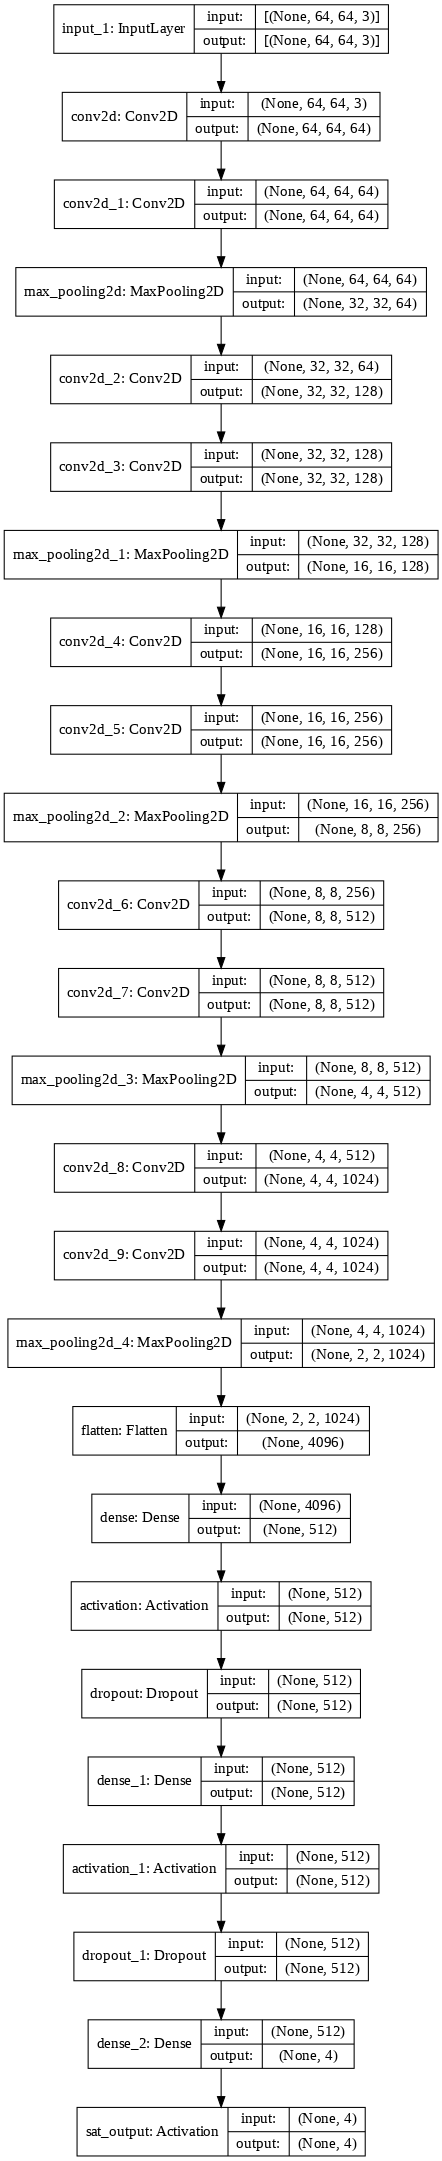

In [ ]:
tf.keras.utils.plot_model(p_model, show_shapes=True, dpi=76, to_file='p_model_v1.png')

In [ ]:
p_model.summary()

Model: "pretext_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       

In [ ]:
init_lr = 1e-4
epochs = 50
opt = Adam(learning_rate=init_lr, amsgrad=False)
p_model.compile(optimizer=opt, 
              loss={
                  'sat_output': 'categorical_crossentropy'},
              
              # loss_weights={
              #     'sat_output': 0.5},
              metrics={
                  'sat_output': 'accuracy'})

In [ ]:
rots_dict = dict()
rots_dict[0] = 1.40
rots_dict[1] = 1.0
rots_dict[2] = 1.40
rots_dict[3] = 1.0
sharps_dict = dict()
sharps_dict[0] = 0.50
sharps_dict[1] = 10.50
sharps_dict[2] = 30.50
sharps_dict[3] = 50.50

In [ ]:
# import os
# os.mkdir('p_model_checkpoint')
# os.mkdir('d_model_checkpoint')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("./p_model_checkpoint", monitor='val_loss')
batch_size = 256
valid_batch_size = 256
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [early_stopping, checkpoint]
history = p_model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    # class_weight=dict(
                    #     rotation_output = rots_dict,
                    #     sharpness_output = sharps_dict
                    # ), 
                    # use_multiprocessing=True,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/50
275/275 [==============================] - 261s 795ms/step - loss: 1.0725 - accuracy: 0.4783 - val_loss: 0.9319 - val_accuracy: 0.5236
INFO:tensorflow:Assets written to: ./p_model_checkpoint/assets
Epoch 2/50
275/275 [==============================] - 209s 762ms/step - loss: 0.7679 - accuracy: 0.6458 - val_loss: 0.6281 - val_accuracy: 0.7084
INFO:tensorflow:Assets written to: ./p_model_checkpoint/assets
Epoch 3/50
275/275 [==============================] - 211s 769ms/step - loss: 0.7209 - accuracy: 0.6652 - val_loss: 0.6217 - val_accuracy: 0.7248
INFO:tensorflow:Assets written to: ./p_model_checkpoint/assets
Epoch 4/50
275/275 [==============================] - 216s 785ms/step - loss: 0.7017 - accuracy: 0.6820 - val_loss: 0.5966 - val_accuracy: 0.7219
INFO:tensorflow:Assets written to: ./p_model_checkpoint/assets
Epoch 5/50
275/275 [==============================] - 216s 786ms/step - loss: 0.6776 - accuracy: 0.6855 - val_loss: 0.5945 - val_accuracy: 0.7235
INFO:tensorflow:As

In [ ]:
plt.clf()
fig = go.Figure(layout_yaxis_range=[0,2])
fig.add_trace(go.Scatter(
                    y=history.history['accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for saturation feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.clf()
fig = go.Figure(layout_yaxis_range=[0,2])
fig.add_trace(go.Scatter(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='loss for saturation feature',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = go.Figure(layout_yaxis_range=[0,1.5])
fig.add_trace(go.Scattergl(
                    y=history.history['loss'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_loss'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Overall loss',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')
fig.show()

In [ ]:
test_batch_size = 256
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
sat_pred= p_model.predict(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

In [ ]:
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
samples = 0
images, rotation_true, sat_true = [], [], []
for test_batch in test_generator:
    image = test_batch[0]
    labels = test_batch[1]
    
    images.extend(image)
    sat_true.extend(labels)
    
sat_true = np.array(sat_true)
sat_true = sat_true.argmax(axis=-1)
sat_pred = sat_pred.argmax(axis=-1)


In [ ]:

# cr_sat = classification_report(sat_true, sat_pred, target_names=dataset_dict['sat_alias'].keys())
# print(cr_sat)

In [ ]:
## Ref: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.
class createAugment(keras.utils.Sequence):
  'Generates data for Keras'
  def __init__(self, X, y, batch_size=128, dim=(64, 64), n_channels=3, shuffle=True):
      'Initialization'
      self.batch_size = batch_size 
      self.X = X 
      self.y = y
      self.dim = dim
      self.n_channels = n_channels
      self.shuffle = shuffle
      
      self.on_epoch_end()

  def __len__(self):
      'Denotes the number of batches per epoch'
      return int(np.floor(len(self.X) / self.batch_size))

  def __getitem__(self, index):
      'Generate one batch of data'
      # Generate indexes of the batch
      indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

      # Generate data
      return self.__data_generation(indexes)

  def on_epoch_end(self):
      'Updates indexes after each epoch'
      self.indexes = np.arange(len(self.X))
      if self.shuffle:
          np.random.shuffle(self.indexes)

  def __data_generation(self, idxs):
    # X_batch is a matrix of masked images used as input
    X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Masked image
    # y_batch is a matrix of original images used for computing error from reconstructed image
    y_batch = np.empty((self.batch_size, self.dim[0], self.dim[1], self.n_channels)) # Original image

    ## Iterate through random indexes
    for i, idx in enumerate(idxs):
      image_copy = self.X[idx].copy()
  
      ## Get mask associated to that image
      masked_image = self.__createMask(image_copy)
      
      X_batch[i,] = masked_image/255
      y_batch[i] = self.y[idx]/255
      
    return X_batch, y_batch

  def __createMask(self, img):
    ## Prepare masking matrix
    mask = np.full((64,64,3), 255, np.uint8)
    for _ in range(np.random.randint(1, 10)):
      # Get random x locations to start line
      x1, x2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random y locations to start line
      y1, y2 = np.random.randint(1, 64), np.random.randint(1, 64)
      # Get random thickness of the line drawn
      thickness = np.random.randint(1, 7)
      # Draw black line on the white mask
      cv2.line(mask,(x1,y1),(x2,y2),(1,1,1),thickness)

    # Perforn bitwise and operation to mak the image
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

In [ ]:
x_train, y_train, x_test, y_test = get_data(get_id_dictionary())

In [ ]:
## Prepare training and testing mask-image pair generator
d_train_gen = createAugment(x_train, x_train, batch_size=256)
d_test_gen = createAugment(x_test, x_test, shuffle=False, batch_size=256)

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

In [ ]:
## Examples
sample_idx = 90 ## Change this to see different batches

sample_masks, sample_labels = d_train_gen[sample_idx]
sample_images = [None]*(len(sample_masks)+len(sample_labels))
sample_images[::2] = sample_labels
sample_images[1::2] = sample_masks

fig = plt.figure(figsize=(16., 8.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes in inch.
                 )

for ax, image in zip(grid, sample_images):
  ax.imshow(image)

plt.show()

In [ ]:
## For more information into formulation: https://www.youtube.com/watch?v=AZr64OxshLo
## Metric
def dice_coef(y_true, y_pred):
    y_true_f = keras.backend.flatten(y_true)
    y_pred_f = keras.backend.flatten(y_pred)
    intersection = keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (keras.backend.sum(y_true_f + y_pred_f))

def dice_loss(y_true, y_pred):
  return 1 - dice_coef(y_true, y_pred)

def ssim_loss(y_true, y_pred):
  return 1 - SSIM(y_true, y_pred, multichannel=True)

def ssim_coef(y_true, y_pred):
  return 1 - SSIM(y_true, y_pred, multichannel=True)

In [ ]:
keras.backend.clear_session()
d_model = inpaintingModel().prepare_model()
depth = 16
  # d_model.layers[:depth]:
  # print(i)
  # layer.set_weights(p_model.layers)
  # d_model.trainable_weights[i].assign(p_model.trainable_weights[i])
for i in range(depth):
  d_model.layers[i].set_weights(p_model.layers[i].get_weights())
  d_model.layers[i].trainable = False
d_model.compile(optimizer='adam', loss= 'mean_absolute_error', metrics=[dice_coef])

keras.utils.plot_model(d_model, show_shapes=True, dpi=76, to_file='d_model_v1.png')

In [ ]:
d_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# d_model.layers[5].get_weights()

# Trying again
## IT WORKS !!!

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
checkpoint = ModelCheckpoint("./d_model_checkpoint", monitor='dice_coef')
batch_size = 256
valid_batch_size = 256
# train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
# valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [early_stopping, checkpoint]
d_history = d_model.fit(d_train_gen,
                    # steps_per_epoch=len(d_train_gen)//batch_size,
                    epochs=4,
                    callbacks=callbacks,
                    # validation_split = 0.25
                    validation_data=d_test_gen,
                    # validation_steps = len(d_test_gen)//batch_size
                    )
                    # class_weight=dict(
                    #     rotation_output = rots_dict,
                    #     sharpness_output = sharps_dict
                    # ), 
                    # use_multiprocessing=True,
                    # validation_data=valid_gen,
                    # validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/4
390/390 [==============================] - 599s 1s/step - loss: 0.0882 - dice_coef: 0.5762 - val_loss: 0.0585 - val_dice_coef: 0.5994
INFO:tensorflow:Assets written to: ./d_model_checkpoint/assets
Epoch 2/4
390/390 [==============================] - 571s 1s/step - loss: 0.0499 - dice_coef: 0.5989 - val_loss: 0.0442 - val_dice_coef: 0.6047
INFO:tensorflow:Assets written to: ./d_model_checkpoint/assets
Epoch 3/4
390/390 [==============================] - 571s 1s/step - loss: 0.0424 - dice_coef: 0.6022 - val_loss: 0.0415 - val_dice_coef: 0.6019
INFO:tensorflow:Assets written to: ./d_model_checkpoint/assets
Epoch 4/4
390/390 [==============================] - 570s 1s/step - loss: 0.0397 - dice_coef: 0.6034 - val_loss: 0.0388 - val_dice_coef: 0.6036
INFO:tensorflow:Assets written to: ./d_model_checkpoint/assets


In [ ]:
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR

In [ ]:
## Examples
rows = 64
sample_idx = 1
sample_images, sample_labels = d_test_gen[sample_idx]

fig, axs = plt.subplots(nrows=rows, ncols=3, figsize=(6, 2*rows))
mean_psnr = 0.0
mean_ssim = 0.0
for i in range(rows):
  impainted_image = d_model.predict(sample_images[i].reshape((1,)+sample_images[i].shape))
  axs[i][0].imshow(sample_labels[i])
  axs[i][1].imshow(sample_images[i])
  axs[i][2].imshow(impainted_image.reshape(impainted_image.shape[1:]))
  mean_psnr += PSNR(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]))
  mean_ssim += SSIM(sample_labels[i],impainted_image.reshape(impainted_image.shape[1:]), multichannel=True)


plt.show()
print(f"Mean PSNR value = {mean_psnr/rows}")
print(f"Mean SSIM value = {mean_ssim/rows}")

Fully supervised is 0.96 on cifar-10 (30 epochs) but yayy 0.85+ in just 2 epochs !!

In [ ]:
print(d_history.history)

In [ ]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=d_history.history['dice_coef'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=d_history.history['val_dice_coef'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for image inpainting',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

input_1 (1, 64, 64, 3) 


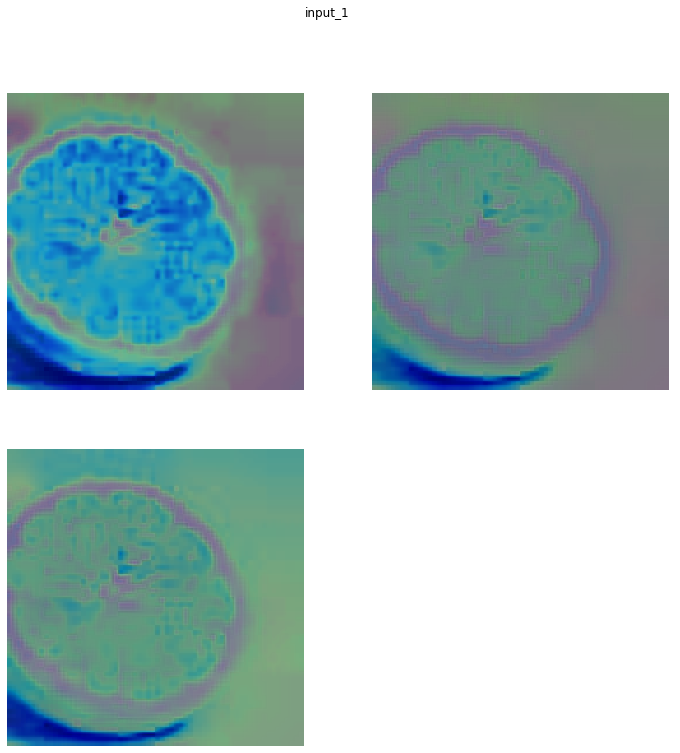

conv2d (1, 64, 64, 64) 


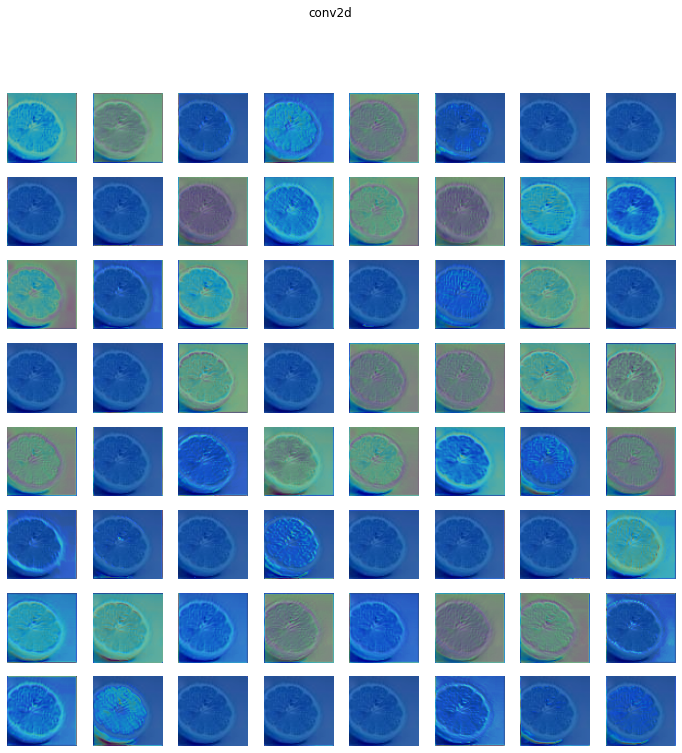

conv2d_1 (1, 64, 64, 64) 


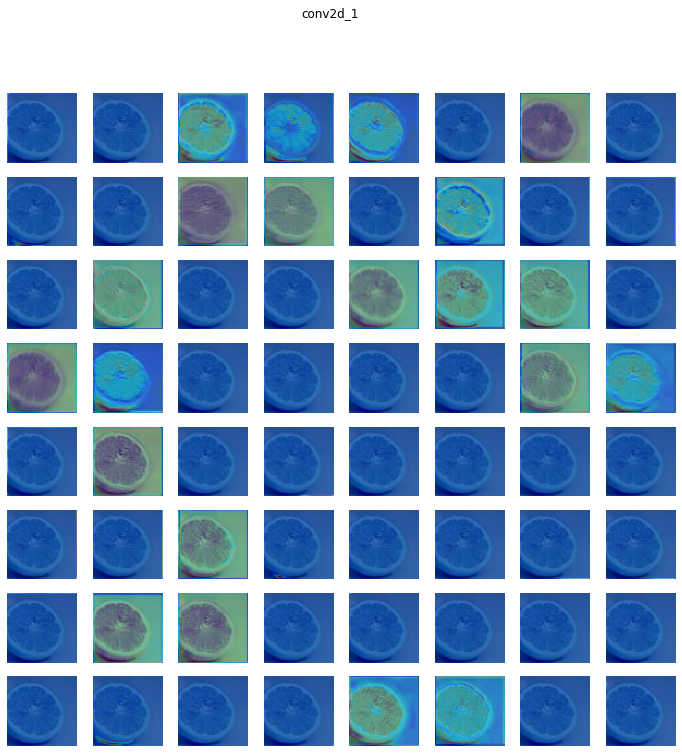

max_pooling2d (1, 32, 32, 64) 


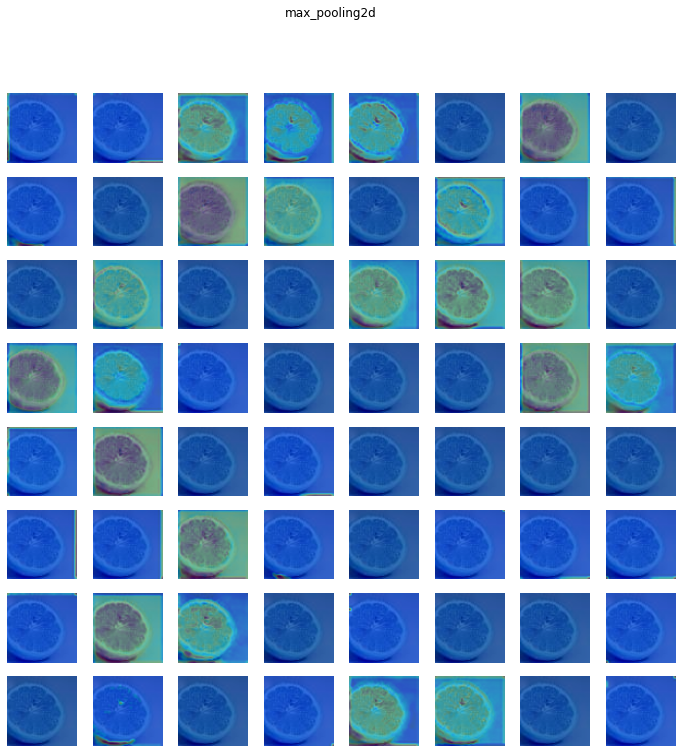

conv2d_2 (1, 32, 32, 128) 


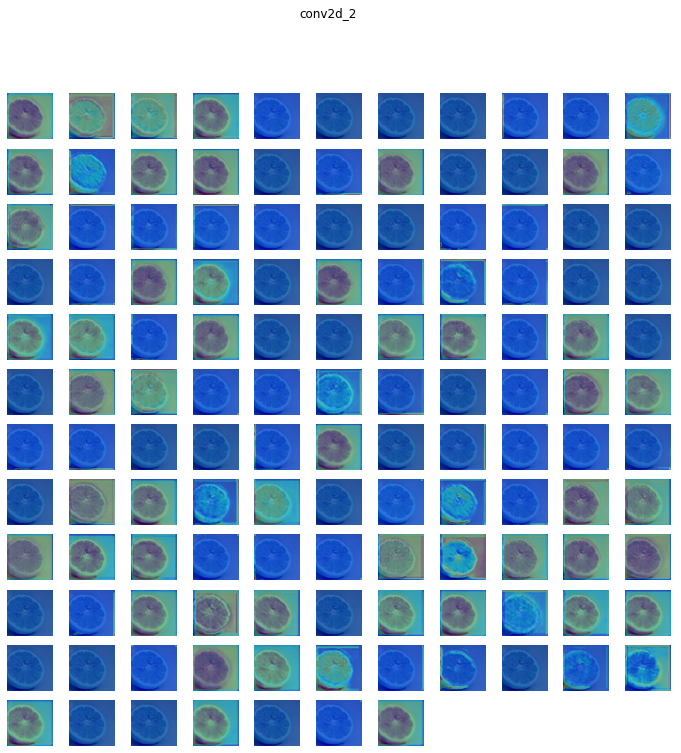

conv2d_3 (1, 32, 32, 128) 


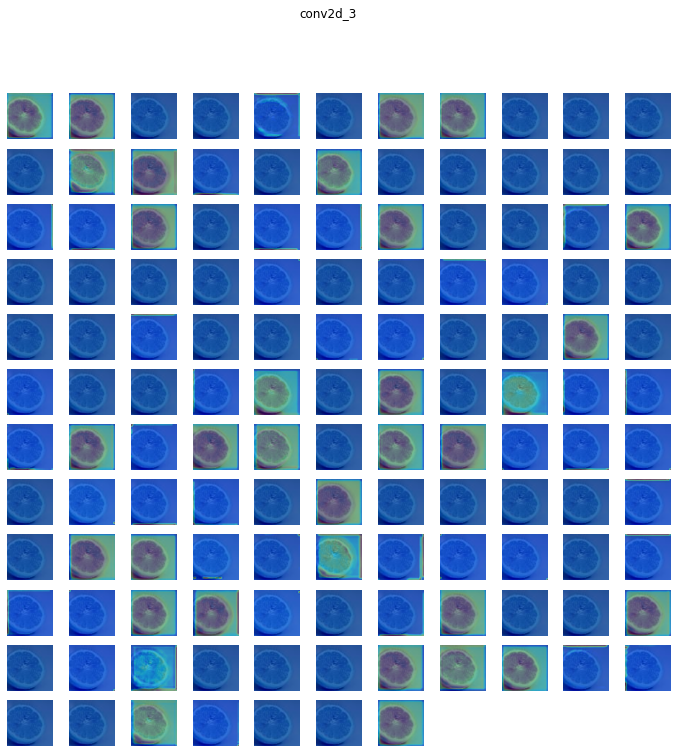

max_pooling2d_1 (1, 16, 16, 128) 


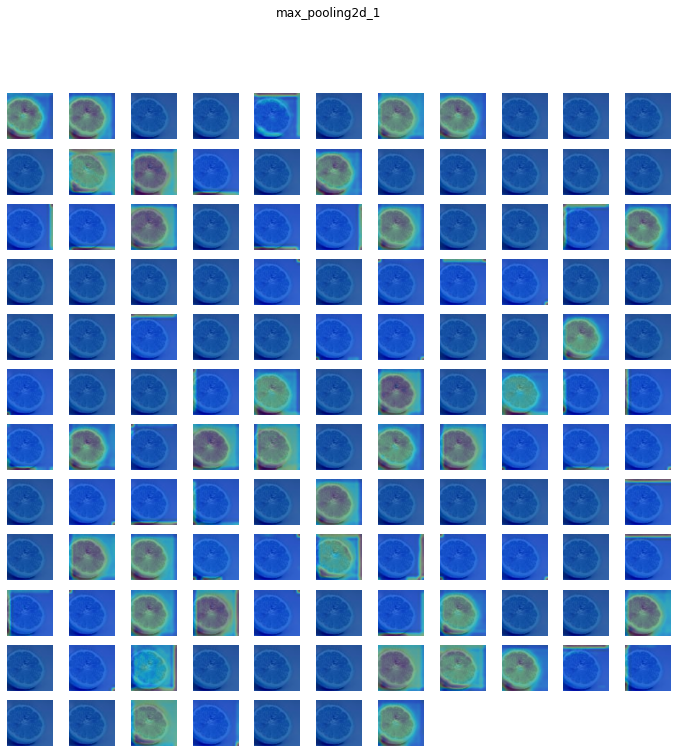

conv2d_4 (1, 16, 16, 256) 


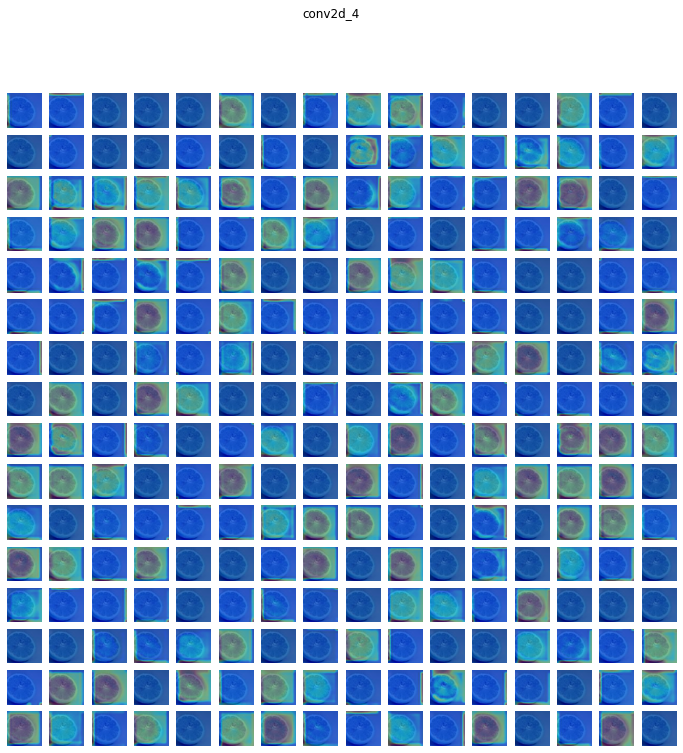

conv2d_5 (1, 16, 16, 256) 


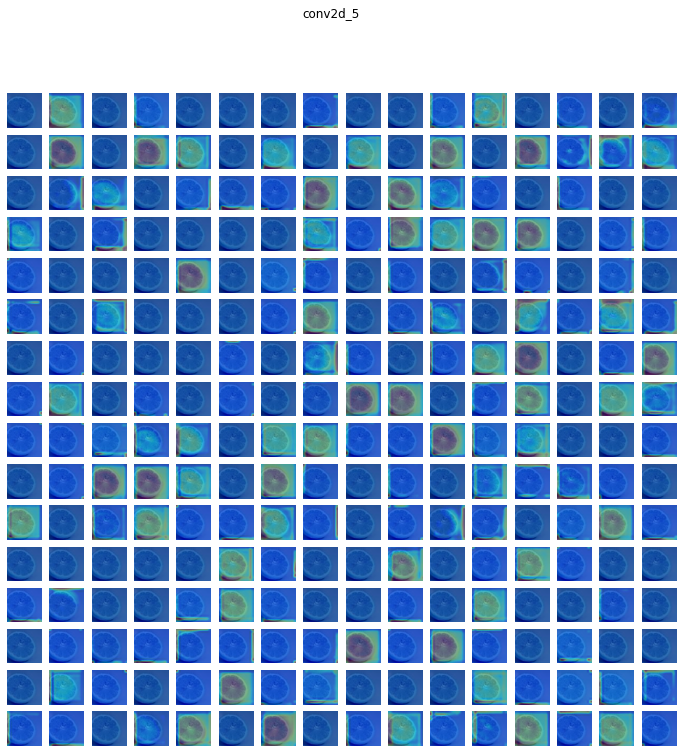

max_pooling2d_2 (1, 8, 8, 256) 


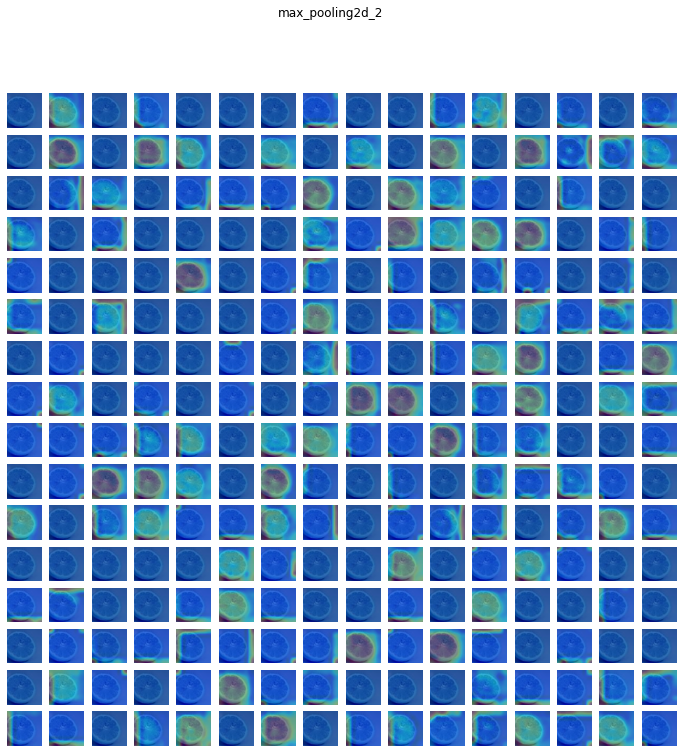

conv2d_6 (1, 8, 8, 512) 


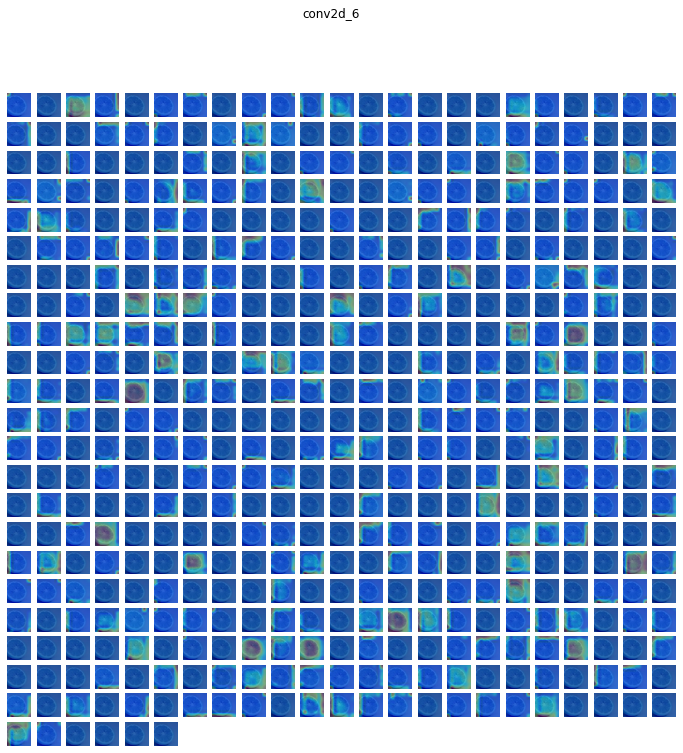

conv2d_7 (1, 8, 8, 512) 


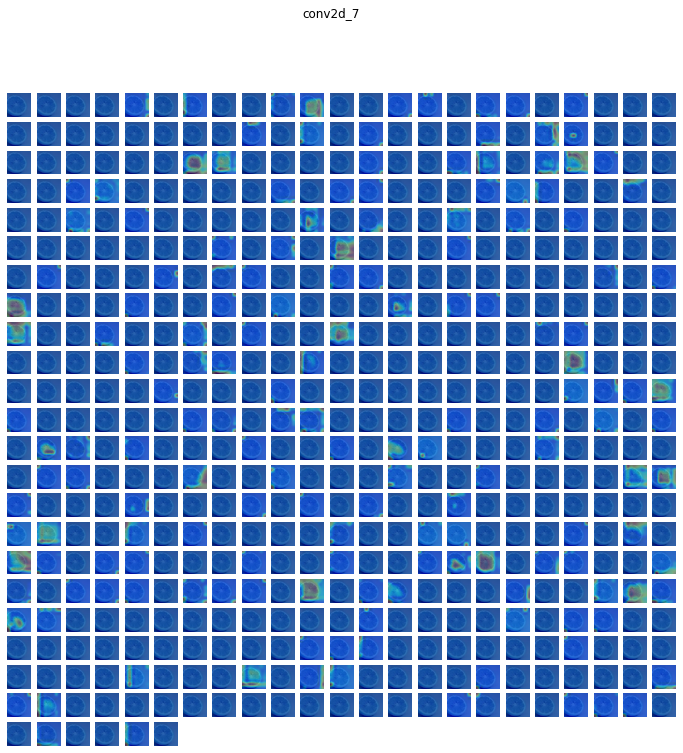

max_pooling2d_3 (1, 4, 4, 512) 


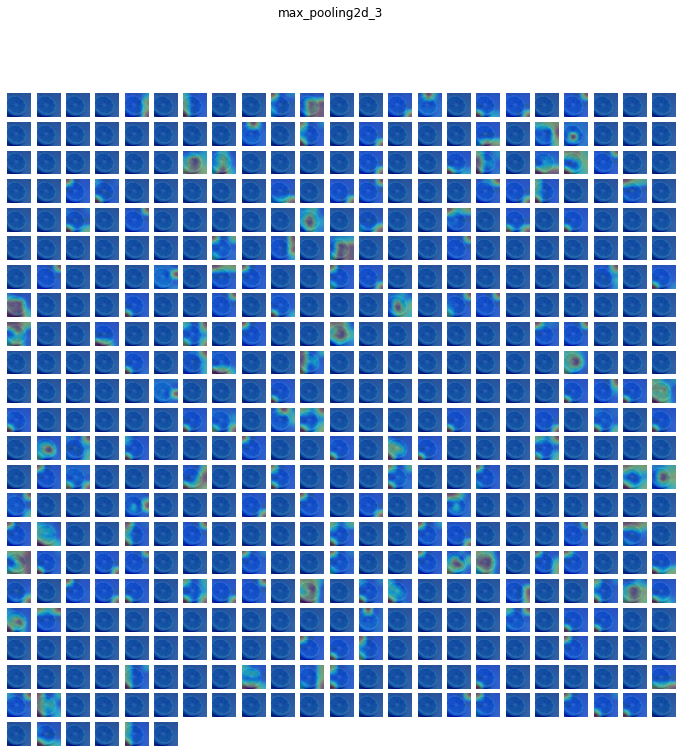

conv2d_8 (1, 4, 4, 1024) 


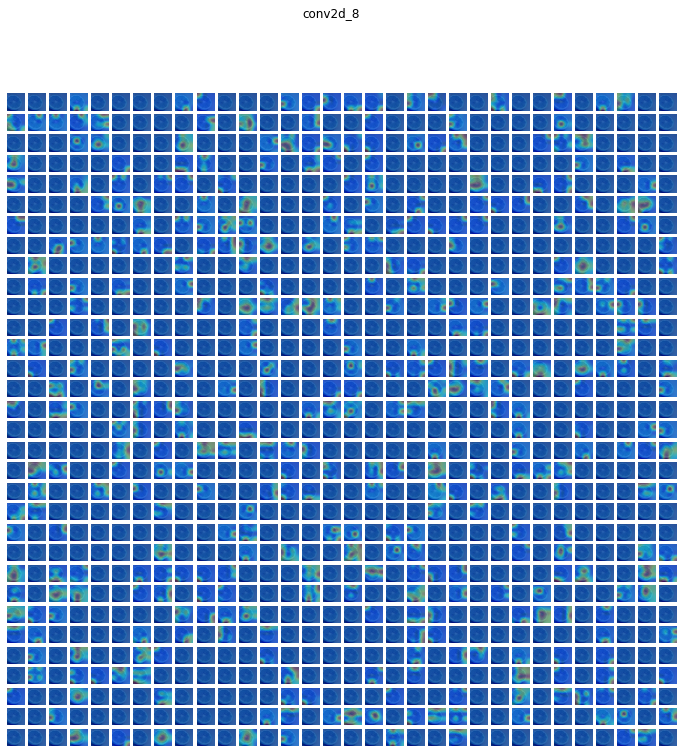

conv2d_9 (1, 4, 4, 1024) 


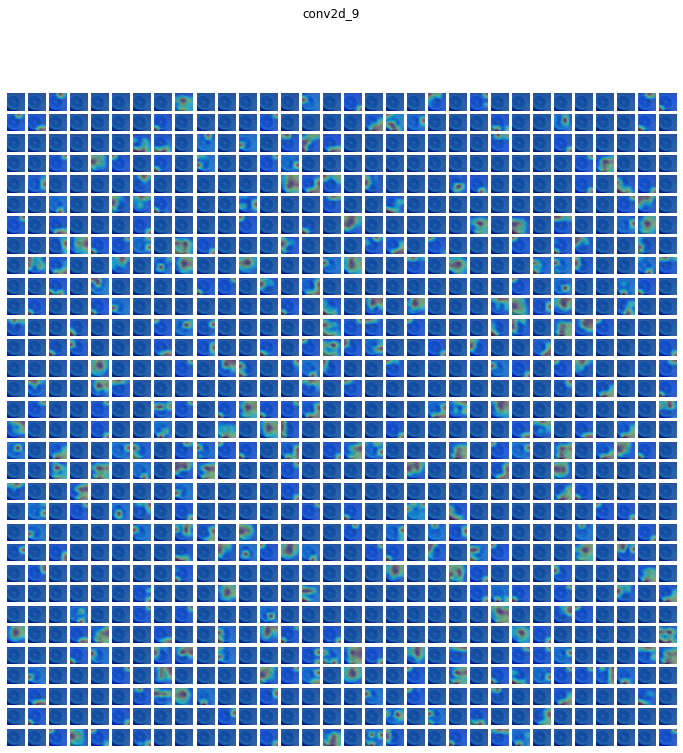

max_pooling2d_4 (1, 2, 2, 1024) 


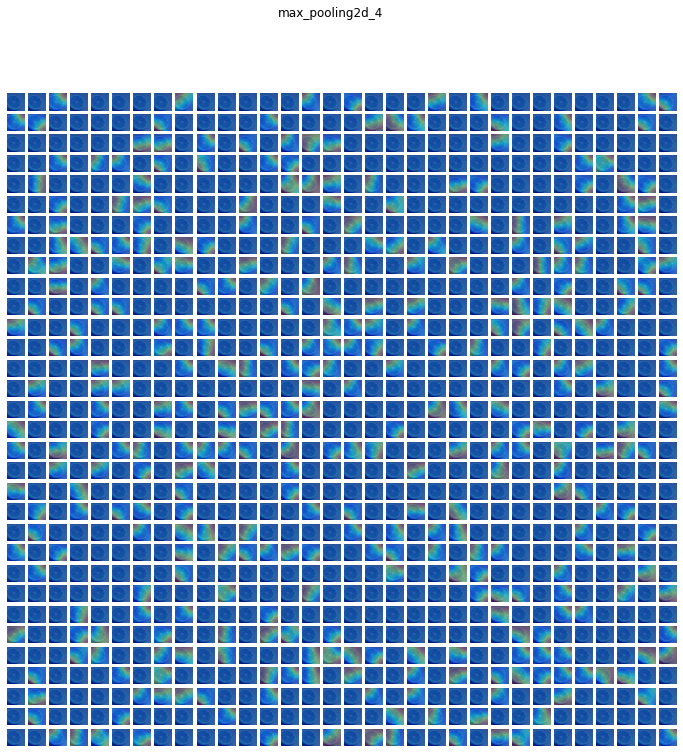

flatten (1, 4096) -> Skipped. 2D Activations.
dense (1, 512) -> Skipped. 2D Activations.
activation (1, 512) -> Skipped. 2D Activations.
dropout (1, 512) -> Skipped. 2D Activations.
dense_1 (1, 512) -> Skipped. 2D Activations.
activation_1 (1, 512) -> Skipped. 2D Activations.
dropout_1 (1, 512) -> Skipped. 2D Activations.
dense_2 (1, 4) -> Skipped. 2D Activations.
sat_output (1, 4) -> Skipped. 2D Activations.


In [ ]:
!pip install keract
import keract
activations = keract.get_activations(p_model, train_data[2499:2500], auto_compile=True)
hm = keract.display_heatmaps(activations, train_data[2499], save=False)